# Modeling Solar Cells with Detailed Balance Model

This notebook demonstrates how to simulate the solar cells with detailed balance model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from pypvcell.solarcell import SQCell,MJCell,DBCell
from pypvcell.illumination import Illumination
from pypvcell.photocurrent import gen_step_qe

font = {'size'   : 12}
matplotlib.rc('font', **font)  # pass in the font dict as kwargs

### Set up the illumination
Initiate an object to for the sun illumination of solar cells

In [2]:
input_ill=Illumination("AM1.5g")

## Simulate a GaAs solar cell at detailed balance limit

Set up a GaAs (Eg=1.42eV) solar cell using ```SQCell```.

In [3]:
gaas_cell=SQCell(eg=1.42,cell_T=293,n_c=1,n_s=1)

Set up the desired illumination

In [4]:
gaas_cell.set_input_spectrum(input_ill)

Generate and draw the I-V characteristics

In [5]:
v,i=gaas_cell.get_iv()

(-400, 0)

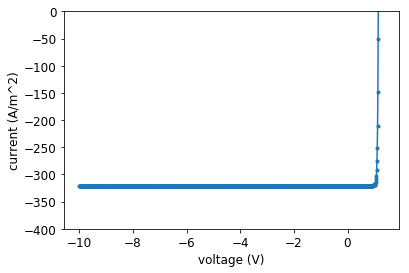

In [6]:
plt.plot(v,i,'.-')
plt.xlabel("voltage (V)")
plt.ylabel("current (A/m^2)")
plt.ylim([-400,0])

## Investigate the optimal band gap 
The follwoing code scans through different band gap and calculate the efficiencies

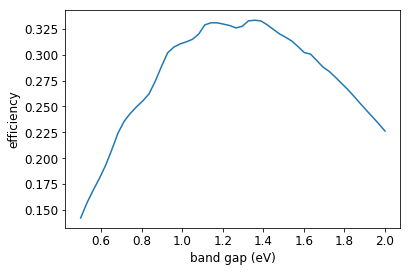

In [7]:
# set up an array of different band gaps
eg_array = np.linspace(0.5, 2.0)
eta_array_air_semi_class=[]
for eg in eg_array:
    sq_cell = SQCell(eg=eg, cell_T=293, n_c=1, n_s=1)
    sq_cell.set_input_spectrum(input_spectrum=input_ill)

    eta_array_air_semi_class.append(sq_cell.get_eta())

plt.plot(eg_array, eta_array_air_semi_class, label="nc=1,ns=1 (class)")
plt.xlabel("band gap (eV)")
plt.ylabel("efficiency")

## Calculate triple-junction cell with Germanium substrate (X/Y/Ge)
This calculation is similar to previous one, but this time we calculate the optimal band gap combinations of top and middle cell of the three-junction solar cell, with germanium cell as the bottom junction.

In [12]:
def get_3j_eta(conc_ill):
    top_eg=np.linspace(1.3,2.1,num=10) # Set up range of top cell band gaps
    mid_eg=np.linspace(0.9,1.5,num=50)# Set up range of middle cell band gaps

    eta=np.zeros((10,50)) # Initialize an array for storing efficiencies

    ge_cell=SQCell(eg=0.67,cell_T=293)
    for i,teg in enumerate(top_eg):
        for j,beg in enumerate(mid_eg):
            tc=SQCell(eg=teg,cell_T=293) # Set up top cell
            bc=SQCell(eg=beg,cell_T=293) # Set up bottom cell
            mj=MJCell([tc, bc,ge_cell]) # Make multijunction cell by "streaming" the 1J cells
            mj.set_input_spectrum(conc_ill) # Set up the illumination
            eta[i,j]=mj.get_eta() # Store the calculated efficiency in an array
    return top_eg,mid_eg,eta

In [13]:
ill=Illumination("AM1.5d",concentration=240)
top_eg,mid_eg,eta=get_3j_eta(ill)

/Users/kanhua/Dropbox/Programming/pypvcell/pypvcell/solarcell.py:40: RuntimeWarning: divide by zero encountered in log
  return rad_eta * np.log(jsc / j01) * thermal_volt * cell_T
/Users/kanhua/miniconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step


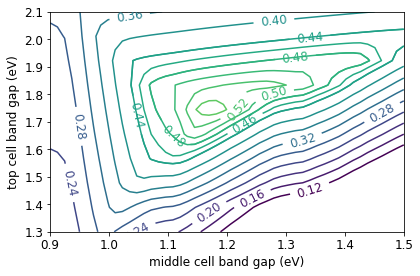

In [14]:
levels=np.unique(np.concatenate((np.arange(0.12,0.7,step=0.04),[0.44,0.46,0.48,0.50,0.54,0.56])))
cs=plt.contour(mid_eg,top_eg,eta,levels)
plt.clabel(cs,levels, fontsize=12, inline=1,fmt="%.2f")
plt.xlabel("middle cell band gap (eV)")
plt.ylabel("top cell band gap (eV)")
plt.tight_layout()
plt.savefig("3J_2d_240suns.png",dpi=600)

In [15]:
tc=SQCell(eg=1.87,cell_T=293) # Set up top cell
bc=SQCell(eg=1.42,cell_T=293) # Set up bottom cell
ge_cell=SQCell(eg=0.67,cell_T=293)
mj=MJCell([tc, bc,ge_cell]) # Make multijunction cell by "streaming" the 1J cells
mj.set_input_spectrum(ill)
print(mj.get_eta())

0.462042258631


## Compare Table II. of the EtaOpt paper
Condition: AM1.5d, Eg=1.13eV, T=300K

In [ ]:
# The AM1.5d spectrum has to be normalized to 1000 W/m^2
input_ill=Illumination("AM1.5d",concentration=1000/918)
sq_cell = SQCell(eg=1.13, cell_T=293, n_c=3.5, n_s=1)
sq_cell.set_input_spectrum(input_spectrum=input_ill)
sq_cell.get_eta()

Condition: 1.84/1.16/0.69

In [ ]:
ill=Illumination("AM1.5d",concentration=462000*1000/918)
mj=MJCell([SQCell(eg=1.84,cell_T=293,n_c=1,n_s=1),
          SQCell(eg=1.16,cell_T=293,n_c=1,n_s=1),
          SQCell(eg=0.69,cell_T=293,n_c=1,n_s=1)])
mj.set_input_spectrum(input_spectrum=ill)
mj.get_eta()

The result does not seemt to match very well (against 67%).

## Calculate optimal band gap on silicon cell (X/1.1eV)
Find the optimal band gap on silicon subcell

In [ ]:
input_ill=Illumination("AM1.5g",concentration=1)
top_eg=np.linspace(1.6,2,num=100) # Set up range of top cell band gaps

eta=np.zeros(100) # Initialize an array for storing efficiencies
jsc_ratio=np.zeros_like(eta)
si_cell=SQCell(eg=1.12,cell_T=293,n_c=3.5,n_s=1)
for i,teg in enumerate(top_eg):
    #qe=gen_step_qe(teg,1)
    #tc=DBCell(qe,rad_eta=1,T=293,n_c=3.5,n_s=1) # Set up top cell
    tc=SQCell(teg,cell_T=293)
    mj=MJCell([tc, si_cell]) # Make multijunction cell by "streaming" the 1J cells
    mj.set_input_spectrum(input_ill) # Set up the illumination
    eta[i]=mj.get_eta() # Store the calculated efficiency in an array
    jsc_a=mj.get_subcell_jsc()
    jsc_ratio[i]=jsc_a[0]/jsc_a[1]
    #print(jsc_a)

In [ ]:
plt.plot(top_eg,eta)
plt.xlabel("band gap of top cell (eV)")
plt.ylabel("efficiency")
plt.savefig("sj_on_si.pdf")

Optimal top cell band gap

In [ ]:
top_eg[np.argmax(eta)]

Maximum efficiency

In [ ]:
np.max(eta)